In [1]:
%%capture
%cd ../..

In [2]:
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from bh2vec.vectors_net import VectorsNetNorm
from bh2vec.tools import hand_to_vec, predict_tricks, vec_to_hand, load_vectors_for_hands
from bh2vec.training import inputs_to_numpy

In [3]:
sns.set_style('whitegrid')

In [4]:
%%capture
# load trained model
net = VectorsNetNorm()
net.load_state_dict(torch.load("models/model.pth"))
net.eval()

In [5]:
# load vectors for test set (50 000 hands)
test_df = pd.read_csv('data/vectorsnet_test.csv', sep=';', index_col=0).reset_index()
vec = load_vectors_for_hands(net, test_df, hand_col='N')
hands = test_df['N']

### Trick prediction estimation errors

In [6]:
errors = pd.read_csv('evaluation/results/errors.csv', sep=';', names=['type', '0.5', '1', '2'])
errors[['0.5', '1', '2']] = errors[['0.5', '1', '2']] * 100 #percentages

In [7]:
errors

,type,0.5,1,2
0,suit,84.196627,99.184370,99.996066
1,nt,72.667003,94.963002,99.781001
2,suit,82.847500,99.052185,99.995685
3,nt,70.559502,94.251251,99.734002
4,suit,84.390312,99.223185,99.996066
5,nt,72.445500,94.973248,99.788249
6,suit,83.374935,99.104625,99.995691
7,nt,71.957499,94.875503,99.788249
8,suit,84.316933,99.191058,99.996001
9,nt,72.792751,95.045501,99.795252


In [8]:
errors.groupby('type').mean()

,0.5,1,2
type,,,
nt,72.212050,94.856851,99.778450
suit,83.951369,99.162080,99.995882


In [9]:
errors.groupby('type').std()

,0.5,1,2
type,,,
nt,0.634289,0.225009,0.018284
suit,0.486673,0.050899,0.000307


In [10]:
errors_rounded = pd.read_csv('evaluation/results/rounded_errors.csv', sep=';', names=['type', '0', '1', '2'])
errors_rounded[['0', '1', '2']] = errors_rounded[['0', '1', '2']] * 100 #percentages

In [11]:
errors_rounded

,type,0,1,2
0,suit,71.484625,99.860375,99.999000
1,nt,63.626500,98.498000,99.920750
2,suit,70.637250,99.847375,99.998750
3,nt,62.129500,98.249500,99.899250
4,suit,71.607500,99.868250,99.999063
5,nt,63.475250,98.494000,99.930000
6,suit,70.961750,99.849688,99.999313
7,nt,63.127250,98.471000,99.926000
8,suit,71.598062,99.862562,99.999313
9,nt,63.686250,98.523250,99.935000


In [12]:
errors_rounded.groupby('type').mean()

,0,1,2
type,,,
nt,63.302100,98.4560,99.922650
suit,71.330981,99.8588,99.999063


In [13]:
errors_rounded.groupby('type').std()

,0,1,2
type,,,
nt,0.445037,0.077174,0.010365
suit,0.313756,0.007122,0.000167


### Means and standard deviations of the vectors' components

In [14]:
vec.mean(axis=0)

array([ 0.00635082,  0.00856771,  0.00928923, -0.00306528, -0.01166376,
       -0.00032885,  0.00428519,  0.01119641], dtype=float32)

In [15]:
vec.std(axis=0)

array([0.9980218, 1.0010686, 1.0023772, 0.9992387, 1.0006986, 1.0006227,
       0.9985068, 1.0045954], dtype=float32)

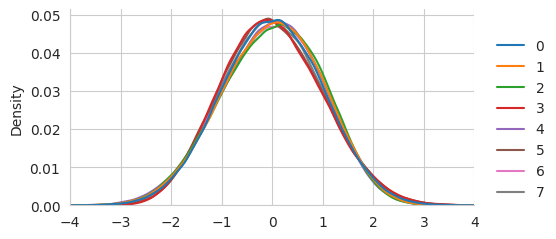

In [16]:
sns.displot(vec, kind='kde', height=2.5, aspect=2);
plt.xlim([-4,4]);

###  Hands with vector representation closest to the zero vector

In [17]:
import numpy as np
np.random.seed(0)

embedding = [0, 0, 0, 0, 0, 0, 0, 0]
for _ in range(4):
    nearest_hand = vec_to_hand(net, embedding)
    print(nearest_hand)

A72.K432.JT9.Q96
QT6.A432.Q95.Q94
QT6.Q95.K432.A32
A62.K432.Q86.Q96


### Nearest neighbours of AKQ2.QJT987.32.2

In [18]:
def euclidean_dist(x1, x2):
    return np.sqrt(((x1 - x2) ** 2).mean())

In [19]:
def find_nn(hand_vec, n=10):
    dist = np.apply_along_axis(lambda x: euclidean_dist(x, hand_vec), axis=1, arr=vec)
    indx = np.argsort(dist)[:n]
    nn_hands, dist = hands[indx], dist[indx]
    return nn_hands, dist

In [20]:
hand = 'AKQ2.QJT987.32.2'
hand_vec = hand_to_vec(net, 'AKQ2.QJT987.32.2')
nn_hands, dist = find_nn(hand_vec)
print('query hand: ', hand)
print('nearest hands: \n', nn_hands)
print('distances: ', dist)

query hand:  AKQ2.QJT987.32.2
nearest hands: 
 171484    AKJ6.QJ6532.T7.9
76343     AQJT.KT9854.J4.7
68529     AKQJ.KJ9864.85.6
58183     AQJT.KJ9654.62.4
137840    AKT5.KT6432.92.5
189473    AKQ9.QJ975.96.64
27575     AKQ85.QJT85.J6.8
159041    AK73.KT8753.J5.J
63399     AKJ8.QJ972.54.T2
37651     AKQ4.QJ873.98.T5
Name: N, dtype: object
distances:  [0.17847475 0.21485098 0.2323068  0.23987351 0.28200358 0.35425144
 0.3619095  0.3628392  0.3643658  0.3657619 ]


### Bridge algebra - approximate solutions of $y + (H_{1}-H_{2})  \approx x$

In [21]:
H1 = 'A82.A7643.Q62.Q5'
H2 = 'A82.Q764.Q62.Q53'
y = '765.Q432.432.432'
H1_vec = hand_to_vec(net, H1)
H2_vec = hand_to_vec(net, H2)
y_vec = hand_to_vec(net, y)

hand_vec = H1_vec - H2_vec + y_vec
# search in the test set
nn_hands, dist = find_nn(hand_vec, n=10)

print('nearest hands: \n', nn_hands)
print('distances: ', dist)

nearest hands: 
 21251     765.A6532.532.72
175350    752.A9542.532.32
183669    T62.A8543.632.62
82417     865.A7432.962.94
188193    T52.A6432.964.32
122791    986.A8765.954.98
24104     653.A9862.972.93
8960      T53.A9852.432.54
86848     432.A9854.753.T8
133291    732.AT862.987.32
Name: N, dtype: object
distances:  [0.1035248  0.10450996 0.12465534 0.129266   0.1420145  0.14563575
 0.14797603 0.14975688 0.1689824  0.18522263]


In [22]:
# general search
for _ in range(5):
    nearest_hand = vec_to_hand(net, hand_vec)
    print(nearest_hand)

654.A8764.642.32
654.A8764.642.32
654.A8764.642.32
654.A8764.642.32
654.A8764.642.32


In [23]:
y = 'J6543.432.32.432'
y_vec = hand_to_vec(net, y)
hand_vec = H1_vec - H2_vec + y_vec

# search in the test set
nn_hands, dist = find_nn(hand_vec, n=10)

print('nearest hands: \n', nn_hands)
print('distances: ', dist)

nearest hands: 
 144417    A7653.9875.63.32
168536    A7532.7632.83.T2
88239     A7652.T763.T3.86
20577     A6432.J853.98.32
52732     T9543.9842.74.98
6512      T7642.7542.62.82
178859    J8643.9753.T5.64
90058     J8543.T842.76.75
99087     T8754.8763.83.T9
97602     J9842.9764.63.42
Name: N, dtype: object
distances:  [0.35283446 0.38360345 0.38587868 0.39052698 0.41316655 0.41640076
 0.42155662 0.42187092 0.42399192 0.42576757]


In [24]:
# general search
for _ in range(4):
    nearest_hand = vec_to_hand(net, hand_vec)
    print(nearest_hand)

A6542.T543.62.64
A6542.T543.62.64
A6542.T543.62.64
A6542.T543.62.64


### $BridgeHand2Vec$ embedded in 2D

In [25]:
from sklearn.manifold import TSNE
import numpy as np
np.random.seed(0)

In [26]:
X, _ = inputs_to_numpy(test_df, swap=False)
X = X[:, :52]
indx = np.random.choice(vec.shape[0], 2000, replace=False)
vec_sel = vec[indx]
hands_sel = X[indx, :]

In [27]:
vec_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=1.5, 
                    random_state=5).fit_transform(vec_sel)

In [28]:
def hcp(hand):
    hcp = hand[[9, 22, 35, 48]].sum() * 1
    hcp += hand[[10, 23, 36, 49]].sum() * 2
    hcp += hand[[11, 24, 37, 50]].sum() * 3
    hcp += hand[[12, 25, 38, 51]].sum() * 4
    return hcp

In [29]:
hcps = np.apply_along_axis(hcp, arr=hands_sel, axis=1)

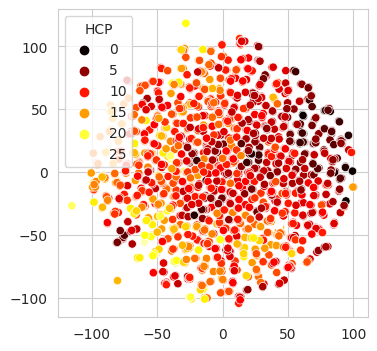

In [30]:
plt.figure(figsize=(4,4))
g = sns.scatterplot(x=vec_embedded[:, 0], y=vec_embedded[:, 1], hue=hcps, palette='hot');
g.legend().set_title('HCP')
plt.savefig('evaluation/results/figs/tsne_hcp.pdf')

In [31]:
n_clubs = hands_sel[:, :13].sum(axis=1)
n_diamonds = hands_sel[:, 13:26].sum(axis=1)
n_hearts = hands_sel[:, 26:39].sum(axis=1)
n_spades = hands_sel[:, 39:].sum(axis=1)

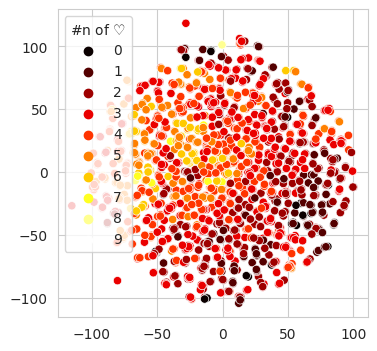

In [32]:
plt.figure(figsize=(4,4))
g = sns.scatterplot(x=vec_embedded[:, 0], y=vec_embedded[:, 1], hue=n_diamonds, palette='hot', legend='full');
g.legend().set_title('#n of $\heartsuit$')
plt.savefig('evaluation/results/figs/tsne_diamonds.pdf')

### RL learning for opening bid

In [33]:
PATH = 'evaluation/results/'
df = pd.read_csv(PATH + 'cem.csv', sep=',')
df_vec = pd.read_csv(PATH + 'cem_vectors.csv', sep=',')
print(df.head())
print(df_vec.head())

df['Value_smooth'] = df['Value'].ewm(com=50).mean()
df_vec['Value_smooth'] = df_vec['Value'].ewm(com=50).mean()

      Wall time  Step       Value
0  1.682342e+09     1 -365.429993
1  1.682342e+09     3 -341.200012
2  1.682342e+09     4 -336.149994
3  1.682342e+09     5 -367.179993
4  1.682342e+09    10 -379.019989
      Wall time  Step       Value
0  1.682342e+09     1 -336.309998
1  1.682342e+09     3 -336.510010
2  1.682342e+09     4 -347.410004
3  1.682342e+09     5 -348.179993
4  1.682342e+09    10 -363.329987


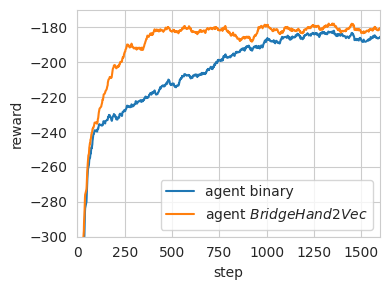

In [34]:
plt.figure(figsize=(4,3))
plt.plot(df['Step'], df['Value_smooth'])
plt.plot(df_vec['Step'], df_vec['Value_smooth'])
plt.xlim(0, 1600);
plt.ylim(-300, -170);
plt.xlabel('step')
plt.ylabel('reward')
plt.legend(['agent binary', 'agent $BridgeHand2Vec$']);
plt.tight_layout()
plt.savefig('evaluation/results/figs/cem_learning.pdf')